# Training Classifier on HashTag data

In [1]:
from nltk.tokenize import TweetTokenizer
import nltk.tokenize.casual as casual
from drevicko.twitter_regexes import cleanString, setupRegexes, tweetPreprocessor
import preprocess_twitter

def preprocess_tweet(text):
    
    text = casual.reduce_lengthening(text)
    text = cleanString(setupRegexes('twitterProAna'),text)   
    text = ' '.join([span for notentity,span in tweetPreprocessor(text, ("urls", "users", "lists")) if notentity])
    text = text.replace('\t','')
    text = text.replace('< ','<')
    text = text.replace(' >','>')
    text = text.replace('):', '<sadface>')
    text = text.replace('(:', '<smile>')
    return text

def tokenise_tweet(text):
    text = preprocess_twitter.tokenize(text)
    text = preprocess_tweet(text)     
    return ' '.join(text.split())

emoNames = ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']

imported regex as re


In [ ]:
import subprocess

subprocess.run( ['wget', 'http://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip'], stdout=subprocess.PIPE )
subprocess.run( ['unzip', 'Jan9-2012-tweets-clean.txt.zip'], stdout=subprocess.PIPE )

In [2]:
from collections import defaultdict
import numpy as np

def _load_data(filename = "Jan9-2012-tweets-clean.txt", preprocess=True):

    lines, tweets_id, tweets_text = [],[],[]

    for line in open(filename, 'rb'):

        line = line.decode("utf-8")
        tw_id = line[0:17]
        tweets_id.append(tw_id)    
        tw_text, tw_emo = line[19:].split("\t:: ")
        
        if(preprocess):
            tw_text = tokenise_tweet(tw_text)
        
        lines.append((tw_text,tw_emo.strip()))
        tweets_text.append(tw_text)

    tweets_set = defaultdict(lambda : {'tweet':'', 'sadness': 0,  'disgust': 0,'surprise': 0,'anger': 0,'fear': 0,'joy': 0})

    for i,t in zip(tweets_id,lines):
        tw, emo = t    
        tweets_set[i]['tweet'] = tw
        tweets_set[i][emo] = 1

    tweets,labels = [],[]

    for i in tweets_set:
        tweets.append(tweets_set[i]['tweet'])
        labels.append([tweets_set[i][e] for e in emoNames])
    
    return(tweets,labels)


tweets, labels = _load_data(filename = "Jan9-2012-tweets-clean.txt", preprocess=True)

## WORD FREQUENCIES

7531 27160
Populating the interactive namespace from numpy and matplotlib


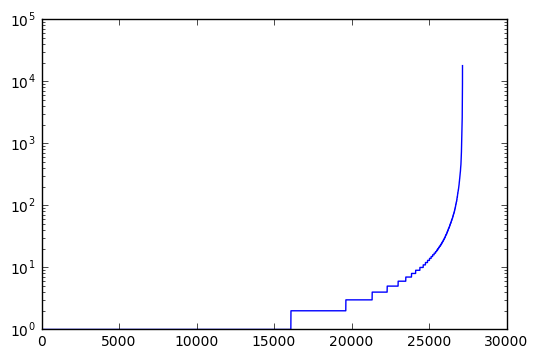

In [4]:
from collections import Counter
from stop_words import get_stop_words
WORD_FREQUENCY_TRESHOLD = 3

import os
from sklearn.externals import joblib


def ifExists(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 
        
def checkFolder(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def _get_unique_tokens(tweets):    
    return(Counter(token for tweet in tweets for token in tweet.split()))

def _save_unique_tokens(tokens, filename='uniqueTokens.dump'):
    
    checkFolder(filename)
    _ = joblib.dump(tokens, filename=filename, compress=9)
    

def _plot_word_frequiencies(uniqueTokens, WORD_FREQUENCY_TRESHOLD = 3):
    
    freqs = []
    for t,c in uniqueTokens.items():
        freqs.append(c)
        
    q = 0
    for t,c in uniqueTokens.items():
        if(c >= WORD_FREQUENCY_TRESHOLD):
            q+=1
    print(q, len(uniqueTokens))
    %pylab inline
    semilogy(arange(len(freqs)),sorted(freqs))
    show()
    

def _reduce_text(text, LANGUAGE='en', WORD_FREQUENCY_TRESHOLD = 3):    

    stop_words = get_stop_words(LANGUAGE)

    tweets_reduced = []

    for tw in tweets:
        tweet_r = []
        for token in tw.split():
            if(uniqueTokens[token] >= WORD_FREQUENCY_TRESHOLD):
                if(not token in stop_words):
                    tweet_r.append(token)

        tweets_reduced.append( ' '.join(tweet_r)  )
        
    return(tweets_reduced)

uniqueTokens = _get_unique_tokens(tweets)
# _save_unique_tokens(tokens=uniqueTokens,filename = '/home/vlaand/IpythonNotebooks/cf-5point-data/uniqueTokens.dump')

_save_unique_tokens(tokens=uniqueTokens,filename = '/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/wordFrequencies.dump')
_plot_word_frequiencies(uniqueTokens, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)
tweets_reduced = _reduce_text(tweets, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

7411 7411
Populating the interactive namespace from numpy and matplotlib


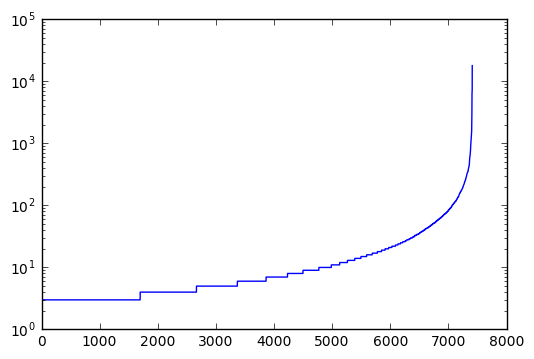

In [5]:
_plot_word_frequiencies(_get_unique_tokens(tweets_reduced), WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

## WORD EMBEDDINGS

In [6]:
EMBEDDINGS_DIM = 100

def _load_original_vectors(filename = 'wordvectors-glove.twitter.27B.200d.txt', sep = ' ', uniqueTokens = None):

    Dictionary = {}
    
    for line in open(filename, 'rb'): 
        line_d = line.decode('utf-8').split(sep)
        token = line_d[0]
        
        token_vector = np.array(line_d[1:], dtype = 'float32')   
        if(uniqueTokens):
            if(token in uniqueTokens):                
                Dictionary[token] = token_vector
        else:
            Dictionary[token] = token_vector
        
            
    return(Dictionary)

# uniqueTokens param is for reading the WE vectors that are present in the text
Dictionary = _load_original_vectors(filename = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt', sep = ' ', uniqueTokens=uniqueTokens)
print(len(Dictionary),'tokens in we')

21760 tokens in we


## N-GRAMS

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
NGRAM_VALUE = 4

print('NGRAM_VALUE =',NGRAM_VALUE)

NGRAM_VALUE = 4


#### Save ngramizer

In [8]:
def _save_ngramizer(ngramizer, filename = 'ngramizer.dump'):
    checkFolder(filename)
    _ = joblib.dump(ngramizer, filename=filename, compress=9)
    print(filename+' saved')
    
vectorizer = CountVectorizer(ngram_range = (1,NGRAM_VALUE),token_pattern=r'\b\w+\b', min_df=WORD_FREQUENCY_TRESHOLD)
ngramizer = vectorizer.fit(tweets_reduced)
vec = ngramizer.transform(tweets_reduced).toarray()
print(len(vec), len(vec[0]))
    
_save_ngramizer(ngramizer = ngramizer, filename = '/home/vlaand/IpythonNotebooks/hashtag-data/ngramizers/ngramizer.dump')
_save_ngramizer(ngramizer = ngramizer, filename = '/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/ngramizers/ngramizer.dump')

21009 18590
/home/vlaand/IpythonNotebooks/hashtag-data/ngramizers/ngramizer.dump saved
/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/ngramizers/ngramizer.dump saved


#### Load ngramizer

In [9]:
def _load_ngramizer(filename = 'ngramizer.dump'):
    checkFolder(filename)
    ngramizer = joblib.load(filename = filename)
    print(filename+' loaded')
    return ngramizer

ngramizer = _load_ngramizer('/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/ngramizers/ngramizer.dump')
vec = ngramizer.transform(tweets_reduced).toarray()
print(len(vec), len(vec[0]))

/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/ngramizers/ngramizer.dump loaded
21009 18590


# SVM

## Vector Transformations

In [10]:
import numpy as np
import math, itertools
from scipy import spatial

def _vectors_similarity(v1 , v2):
    return( 1 - spatial.distance.cosine(v1,v2) )

def capitalRatio(tweet):
    
        firstCap, allCap = 0, 0
        length = len(tweet)
        if length==0:
            return np.array([0,0])

        for i,token in enumerate(tweet.split()):
            if( token.istitle() ):
                firstCap += 1
            elif( token.isupper() ):
                allCap += 1
        return(np.asarray([firstCap/length,allCap/length]))  
        

def tweetToWordVectors(dictionary, tweet, fixedLength=False):
    output = []    
    if(fixedLength):
        for i in range(MAX_SEQUENCE_LENGTH):
            output.append(blankVector)
        for i,token in enumerate(tweet.split()):
            if token in Dictionary:
                output[i] = Dictionary[token]                
    else:
         for i,token in enumerate(tweet.lower().split()):
            if token in Dictionary:
                output.append(Dictionary[token])            
    return(output)

def ModWordVectors(x, mod=True):
    if(len(x) == 0):       
        if(mod):
            return(np.zeros(EMBEDDINGS_DIM*3, dtype='float32'))
        else:
            return(np.zeros(EMBEDDINGS_DIM, dtype='float32'))        
    m =  np.matrix(x)
    if(mod):
        xMean = np.array(m.mean(0))[0]
        xMin = np.array(m.min(0))[0]
        xMax = np.array(m.max(0))[0]
        xX = np.concatenate((xMean,xMin,xMax))
        return(xX)
    else:
        return(np.array(m.mean(0))[0])

def bindTwoVectors(x0,x1):
    xX = np.array(list(itertools.chain(x0,x1)),dtype='float32')
    return(xX)   

def _bind_vectors(x):
    xX = np.concatenate(x)
    return(xX)     

def _convert_text_to_vector(tweets, tweet_original,  Dictionary):

    X = []
    y = []
    for i, t in enumerate(tweets): 
        embeddingsVector = ModWordVectors(tweetToWordVectors(Dictionary,tweets[i]))
        capitalRatioVector = capitalRatio(tweet_original[i])
        ngramVector = vec[i]
        X.append( _bind_vectors((ngramVector, capitalRatioVector, embeddingsVector))  )
        y.append(labels[i])
    
    return(np.asarray(X), y)


X,y = _convert_text_to_vector(tweets = tweets_reduced, tweet_original = tweets, Dictionary = Dictionary)
  
print(len(X), len(X[0]), len(y), len(y[0]))

21009 18892 21009 6


## GridSearch

In [57]:
from sklearn.svm import SVC, LinearSVC
from sklearn.externals import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from collections import Counter
from multiprocessing import Pool
import warnings

warnings.simplefilter('ignore')

ESTIMATOR = 'LinearSVC'
cv_folds = 5

def foo(EMOTION=0):   
    rs = np.random.randint(low = 0, high = len(X),size = int(len(X)/100))    
    # X, y2 = X[rs], y2[rs]
    
    y2 = []
    for ly in y:   
        y2.append(int(ly[EMOTION]))        
    y2 = np.asarray(y2)
    
    if(EMOTION == 5):
        foo2(X_3[rs], y2[rs], EMOTION=EMOTION)
    elif(EMOTION == 3):
        foo2(X_2[rs], y2[rs], EMOTION=EMOTION)
    else:
        foo2(X[rs], y2[rs], EMOTION=EMOTION)

def foo2(X,y,EMOTION=0): 
           

    list_acc = []    
    list_val = []
        
    if(ESTIMATOR == 'LinearSVC'):                             
        epsilon = 0.001
        gamma=1.0
        for tol in [1e-6,1e-5,1e-4]:
            for C in [0.01,0.1,1.0]:
                cvs = cross_val_score(estimator = LinearSVC(C=C, class_weight='balanced', penalty='l1', dual=False, tol=tol), X=X, y=y, cv=cv_folds, n_jobs=cv_folds, scoring='f1') 
                meanScore = np.mean(np.asarray(cvs))
                list_val.append([emoNames[EMOTION],meanScore,ESTIMATOR, C, gamma,epsilon,tol,NGRAM_VALUE,EMBEDDINGS_DIM])
                list_acc.append(meanScore)
                print(emoNames[EMOTION]+': C='+str(C)+', tol='+str(tol)+', score='+str(meanScore))
        best = np.argmax(list_acc)
        print(list_val[best])
        
    elif(ESTIMATOR == 'SVC'):                          
        epsilon = 0.001
        for gamma in [0.001,0.01,0.1,1.0]:
            for tol in [1e-6,1e-5,1e-4]:
                for C in [0.001,0.01,0.1,1.0]:
                    cvs = cross_val_score(estimator = SVC(C=C, class_weight='balanced', tol=tol, gamma=gamma), X=X, y=y, cv=cv_folds, n_jobs=cv_folds, scoring='f1') 
                    meanScore = np.mean(np.asarray(cvs))
                    list_val.append([emoNames[EMOTION],meanScore,ESTIMATOR, C, gamma,epsilon,tol,NGRAM_VALUE,EMBEDDINGS_DIM])
                    list_acc.append(meanScore)
                    print(emoNames[EMOTION]+': C='+str(C)+', tol='+str(tol)+', score='+str(meanScore))
        best = np.argmax(list_acc)
        print(list_val[best])
        
    return list_val[best]
            

# print('emotion, f1_score, estimator, C, gamma, epsilon, tol, ngrams, EMBEDDINGS_DIM')  
p = Pool(processes = 6)
results = p.map(foo, [i for i in  range(len(emoNames))])
# foo(5)

anger: C=0.001, tol=1e-06, score=0.139903381643
surprise: C=0.001, tol=1e-06, score=0.32
fear: C=0.001, tol=1e-06, score=0.139903381643
disgust: C=0.001, tol=1e-06, score=0.0
joy: C=0.001, tol=1e-06, score=0.0
sadness: C=0.001, tol=1e-06, score=0.125490196078
anger: C=0.01, tol=1e-06, score=0.0
surprise: C=0.01, tol=1e-06, score=0.0
disgust: C=0.01, tol=1e-06, score=0.0
fear: C=0.01, tol=1e-06, score=0.0
sadness: C=0.01, tol=1e-06, score=0.0
joy: C=0.01, tol=1e-06, score=0.0
anger: C=0.1, tol=1e-06, score=0.139903381643
surprise: C=0.1, tol=1e-06, score=0.216752136752
disgust: C=0.1, tol=1e-06, score=0.0563636363636
sadness: C=0.1, tol=1e-06, score=0.0
fear: C=0.1, tol=1e-06, score=0.139903381643
joy: C=0.1, tol=1e-06, score=0.0
anger: C=1.0, tol=1e-06, score=0.148666666667
surprise: C=1.0, tol=1e-06, score=0.133333333333
disgust: C=1.0, tol=1e-06, score=0.0210526315789
sadness: C=1.0, tol=1e-06, score=0.0
joy: C=1.0, tol=1e-06, score=0.11826625387
fear: C=1.0, tol=1e-06, score=0.44761

[None, None, None, None, None, None]

In [ ]:
['sadness', 0.42615384615384605, 'SVC', 1.0, 0.01, 0.001, 1e-06, 4, 200]
['disgust', 0.14666666666666667, 'SVC', 0.1, 0.01, 0.001, 1e-06, 4, 200]
['surprise', 0.32000000000000001, 'SVC', 0.001, 0.001, 0.001, 1e-06, 4, 200]
['anger', 0.18157004830917872, 'SVC', 0.001, 0.1, 0.001, 1e-06, 4, 200]
['fear', 0.44761904761904764, 'SVC', 1.0, 0.001, 0.001, 1e-06, 4, 200]
['joy', 0.56468075639599558, 'SVC', 1.0, 0.01, 0.001, 1e-06, 4, 200]


## SAVE CLASSIFIERS

In [11]:
train_params_linear = {
        'sadness': {'C': 0.1, 'tol':1.00E-04},
        'disgust': {'C': 0.1, 'tol':1.00E-04},
        'surprise': {'C': 0.1, 'tol':1.00E-06},
        'anger': {'C': 1.0, 'tol':1.00E-05},
        'fear': {'C': 1.0, 'tol':1.00E-04},
        'joy': {'C': 0.1, 'tol':1.00E-04}
    }

train_params_rbf = {
        'sadness': {'C': 0.1, 'gamma': 0.01, 'tol':1.00E-05},
         'disgust': {'C': 0.1, 'gamma': 0.01, 'tol':1.00E-04},
         'surprise': {'C': 0.1, 'gamma': 0.001, 'tol':1.00E-06},
         'anger': {'C': 1.0, 'gamma': 0.1, 'tol':1.00E-05},
         'fear': {'C': 1.0, 'gamma': 0.001, 'tol':1.00E-05},
         'joy': {'C': 0.1, 'gamma': 0.01, 'tol':1.00E-04}
    }

train_params = {'LinearSVC':train_params_linear, 'SVC':train_params_rbf}

## Train and Save the Classifiers

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.externals import joblib
from multiprocessing import Pool
import os
# from collections import Counter

SEP = '/'
EXTENSION = '.dump'
ESTIMATOR = 'SVC'

def ifExists(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def trainModelFor(X, y, EMOTION=0):
    
    y2 = []
    for ly in y:  
        y2.append(int(ly[EMOTION]))        
    y2 = np.asarray(y2)
    
#     rs = np.random.randint(low = 0, high = len(X),size = int(len(X)/100))    
#     X, y2 = X[rs], y2[rs]
    
    
    C = train_params[ESTIMATOR][ emoNames[EMOTION] ]['C'] 
    tol = train_params[ESTIMATOR][ emoNames[EMOTION] ]['tol']    
        
    class_weight = 'balanced'     

   
    if(ESTIMATOR == 'LinearSVC'):
        svcTrained = LinearSVC(C=C, class_weight='balanced', penalty='l1', dual=False, tol=tol)
        svcTrained.fit(X, y2)
    elif(ESTIMATOR == 'SVC'):
        gamma = train_params[ESTIMATOR][ emoNames[EMOTION] ]['gamma'] 
        svcTrained = SVC(C=C, gamma=gamma, class_weight='balanced', tol=tol, probability=True)
        svcTrained.fit(X, y2)
        
    return(svcTrained)

def checkFolder(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def saveModelFor(model, EMOTION=0):
    path = '/home/vlaand/IpythonNotebooks/05_emotion_hashtags_nuig/hashTagClassification/classifiers'
    path = path +SEP+ESTIMATOR
    checkFolder(path)
    filename = path + SEP +str(emoNames[EMOTION]) + EXTENSION
    checkFolder(filename)
    _ = joblib.dump(model, filename, compress=9)

    print('model ' + filename + ' saved')
    
def trainAndSave(emotion):
#     if(emotion == 5):
#         saveModelFor( EMOTION=emotion, model=trainModelFor(X, EMOTION=emotion) )
#     elif(emotion == 3):
#         saveModelFor( EMOTION=emotion, model=trainModelFor(X, EMOTION=emotion) )
#     else:
        saveModelFor( EMOTION=emotion, model=trainModelFor(X, y, EMOTION=emotion) )

with Pool(processes = 6) as p: 
    p.map(trainAndSave, [i for i in range(len(emoNames))])